In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import Airline passenger traffic data

In [2]:
data = pd.read_csv('Temprature2.csv', header=None)
data.columns=['Month', 'Passengers']
data['Month'] = pd.to_datetime(data['Month'], format="%Y-%m")
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


## Time Series analysis

### Plot time series data

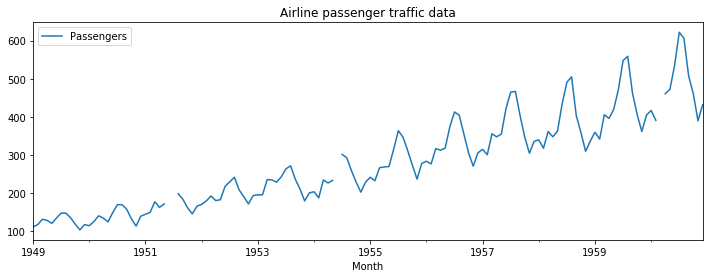

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title("Airline passenger traffic data")
plt.show(block=False)

### Missing value treatments

#### mean imputation

In [4]:
data = data.assign(Passengers_Mean_imputation = data.Passengers.fillna(data.Passengers.mean()))
data.head()

,Passengers,Passengers_Mean_imputation
Month,,
1949-01-01,112.0,112.0
1949-02-01,118.0,118.0
1949-03-01,132.0,132.0
1949-04-01,129.0,129.0
1949-05-01,121.0,121.0


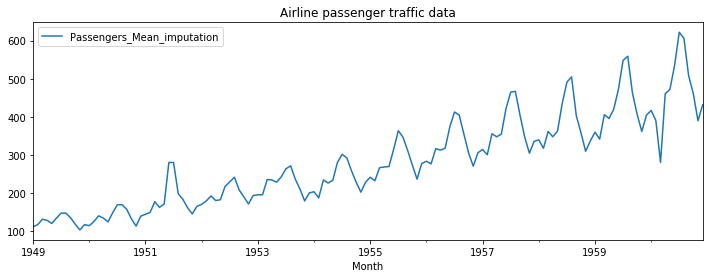

In [5]:
data[['Passengers_Mean_imputation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title("Airline passenger traffic data")
plt.show(block=False)

### Linear interpolation

In [6]:
data = data.assign(Passengers_Linear_Interpolation = data.Passengers.interpolate(method='linear'))

In [7]:
data['Passengers'] = data.Passengers_Linear_Interpolation
data.drop(['Passengers_Mean_imputation', 'Passengers_Linear_Interpolation'],axis=1 , inplace=True)

## Time series decomposition

### Additive seasonal decomposition

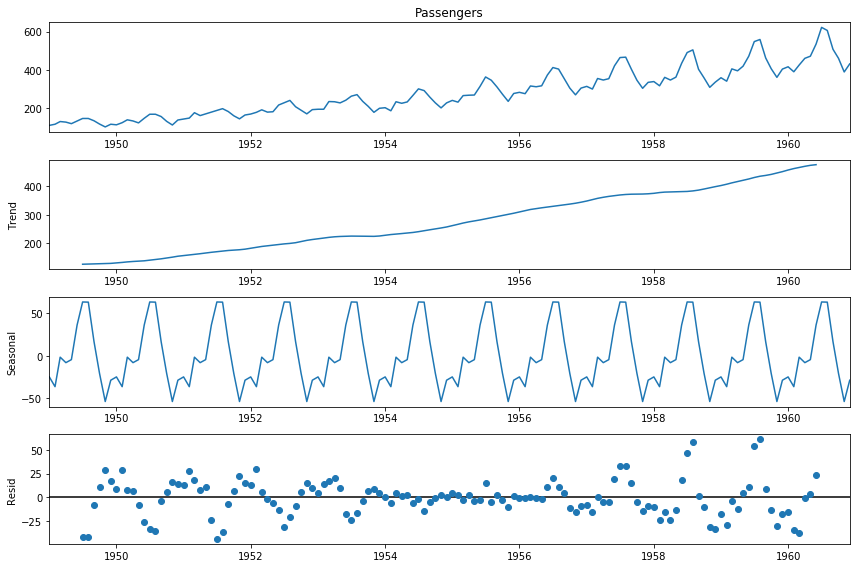

In [8]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive')
fig = decomposition.plot()
plt.show()

## Multiplicative seasonal decomposition

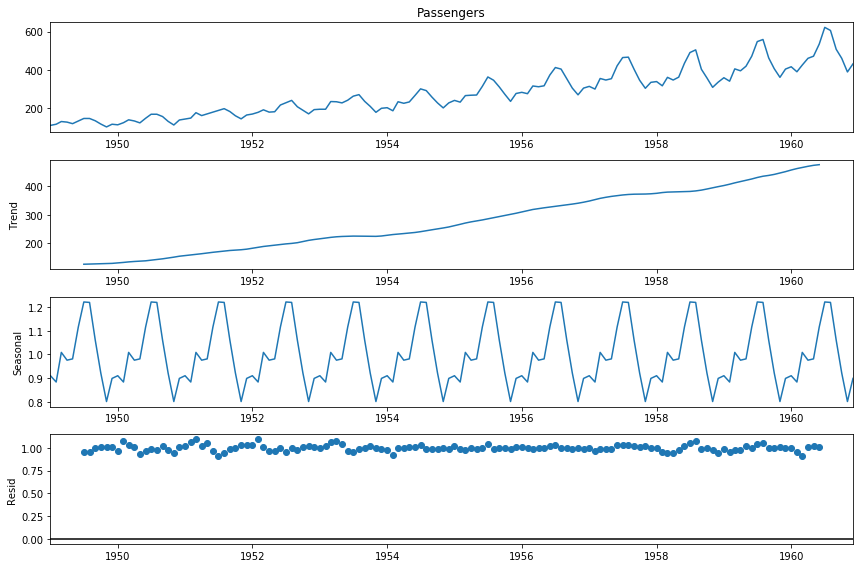

In [9]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Build and evaluate time series forecast

### Splitting time series into training and test sets

In [10]:
train_len = 120 # cannot use random methods like train_test split since order is important. 
train = data[:train_len] # before 1959
test = data[train_len:] # this is 1959- onwards

In [11]:
train.tail(5)

,Passengers
Month,
1958-08-01,505.0
1958-09-01,404.0
1958-10-01,359.0
1958-11-01,310.0
1958-12-01,337.0


In [12]:
test.head(5)

,Passengers
Month,
1959-01-01,360.0
1959-02-01,342.0
1959-03-01,406.0
1959-04-01,396.0
1959-05-01,420.0


### Naive method

In [13]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1] # last observation in train data is our prediction

### Plot train, test and forecast

Text(0.5, 1.0, 'Naive Method')

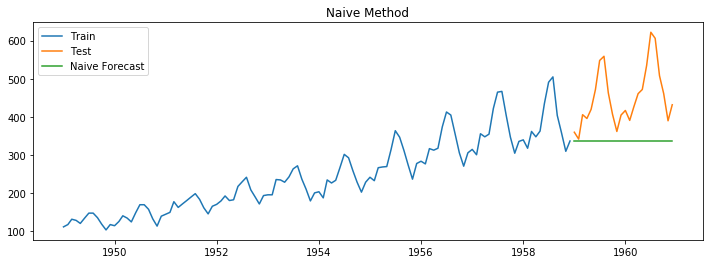

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Method')

## Simple average method

In [15]:
y_hat_average = test.copy()
y_hat_average['avg_forecast'] = train['Passengers'].mean()

Text(0.5, 1.0, 'Simple Average Method')

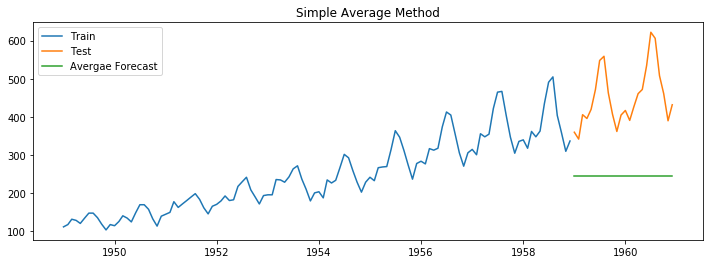

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_average['avg_forecast'], label='Avergae Forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')

## Calculate RMSe and MAPE to evaluate forecast

In [17]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_naive['naive_forecast'])/test['Passengers'])*100, 2)

In [18]:
results = pd.DataFrame({'Method':['Naive method'], 'MAPE':[mape], 'RMSE':[rmse]})
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51


### Simple moving average method

In [19]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
# adjustment for test period. since the window is not avialable fully we fill it with the first computed value
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len]

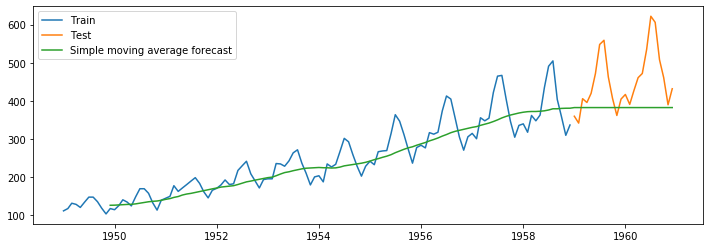

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label = 'Simple moving average forecast')
plt.legend(loc='best')

In [21]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100, 2)

In [22]:
rmse, mape

(102.18, 15.28)

In [23]:
y_hat_sma = data.copy()
ma_window = 6
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
# adjustment for test period
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len]

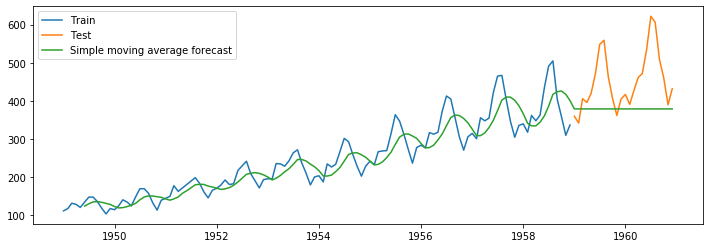

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label = 'Simple moving average forecast')
plt.legend(loc='best')

In [25]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100, 2)

In [26]:
rmse, mape

(104.61, 15.82)

## Simple Exponential Smoothing

In [27]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit =  model.fit(smoothing_level= 0.2, optimized = False) # smoothing level is the alpha
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] =  model_fit.forecast(24) #24 = number of months or time intervals to be predicted

{'smoothing_level': 0.2, 'smoothing_slope': None, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


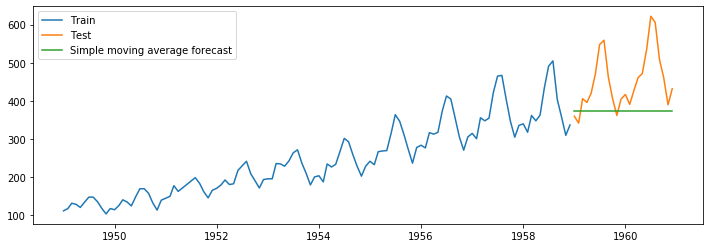

In [28]:
### plot train test and forecast
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label = 'Simple moving average forecast')
plt.legend(loc='best')

In [29]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_ses['ses_forecast'])/test['Passengers'])*100, 2)
rmse, mape

(107.65, 16.49)

### Holt's exponential smoothing method with Trend

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(train['Passengers']), seasonal_periods = 12, trend = 'additive', seasonal=None)
model_fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.01 ,optimized = False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train test and forecast

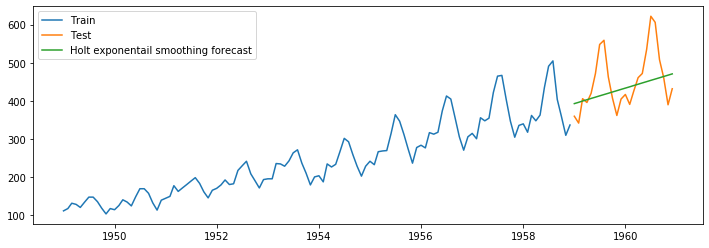

In [31]:
### plot train test and forecast
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label = 'Holt exponentail smoothing forecast')
plt.legend(loc='best')

### Holt winter's additive method with trend and seasonality

In [32]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12 , trend = 'add', seasonal ='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2631578931410015, 'smoothing_slope': 0.05162966025765116, 'smoothing_seasonal': 0.7368421036673173, 'damping_slope': nan, 'initial_level': 211.55099866332293, 'initial_slope': 1.7391915752033313, 'initial_seasons': array([-100.18118437,  -94.2046477 ,  -80.29175565,  -83.41758365,
        -91.45908078,  -77.4509434 ,  -64.48324357,  -64.57340564,
        -76.66644176,  -93.73584142, -108.67610965,  -94.50947707]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


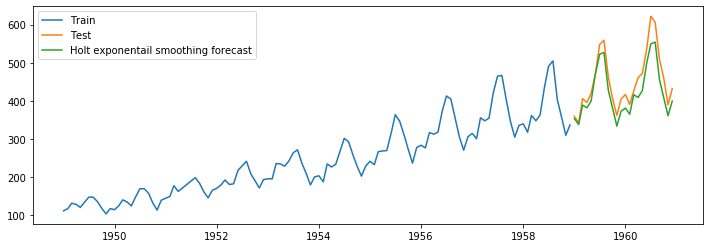

In [33]:
### plot train test and forecast
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hwa_forecast'], label = 'Holt exponentail smoothing forecast')
plt.legend(loc='best')

In [34]:
# calcualte rmse, mape as above

rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_hwa['hwa_forecast'])/test['Passengers'])*100, 2)

In [35]:
rmse, mape

(35.1, 6.53)

## Holt winters multiplicative method with trend and seasonality

In [36]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12 , trend = 'add', seasonal ='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.38297792357726124, 'smoothing_slope': 0.035502695358352605, 'smoothing_seasonal': 0.6170220681283785, 'damping_slope': nan, 'initial_level': 212.3983506469908, 'initial_slope': 1.095376632423797, 'initial_seasons': array([0.51702061, 0.5454338 , 0.60215765, 0.56916567, 0.51982655,
       0.57235007, 0.62776238, 0.62555286, 0.57005795, 0.49511555,
       0.43967716, 0.51387414]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


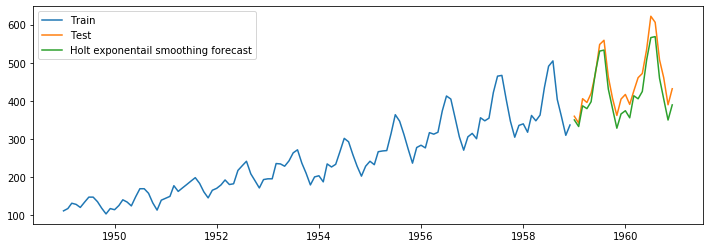

In [37]:
### plot train test and forecast
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hwa_forecast'], label = 'Holt exponentail smoothing forecast')
plt.legend(loc='best')

In [38]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_hwa['hwa_forecast'])/test['Passengers'])*100, 2)

In [39]:
rmse, mape

(34.87, 6.92)

### Augmented Dickey-Fuller test (ADF) test

In [40]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'].dropna())
adf_test
print('ADF statistic: %f' % adf_test[0])
print('Critical value @0.05: %.2f' %adf_test[4]['5%'] )
print('p-value: %f' %adf_test[1])

ADF statistic: 0.894609
Critical value @0.05: -2.88
p-value: 0.993020


### KPSS test 

In [41]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(data['Passengers'].dropna())

print('KPSS statistic %f' % kpss_test[0])
print('Critical value @ 0.05: %.2f' %kpss_test[3]['5%'])
print('p-value %f' % kpss_test[1])

KPSS statistic 1.052050
Critical value @ 0.05: 0.46
p-value 0.010000


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


## Box Cox transformation

In [42]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index=data.index)
data_boxcox

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Length: 144, dtype: float64

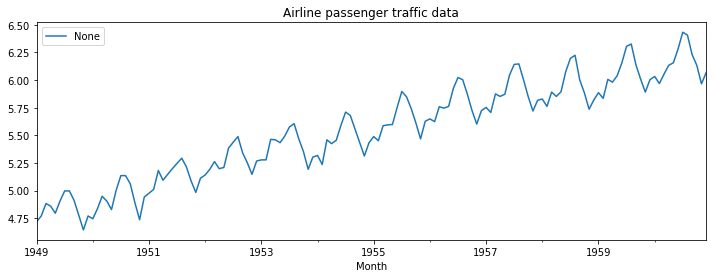

In [43]:
data_boxcox.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title("Airline passenger traffic data")
plt.show(block=False)

variance has become constant

## Differencing

In [44]:
data_boxcox_diff = pd.Series(data_boxcox-data_boxcox.shift(), index=data.index)
data_boxcox_diff

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Length: 144, dtype: float64

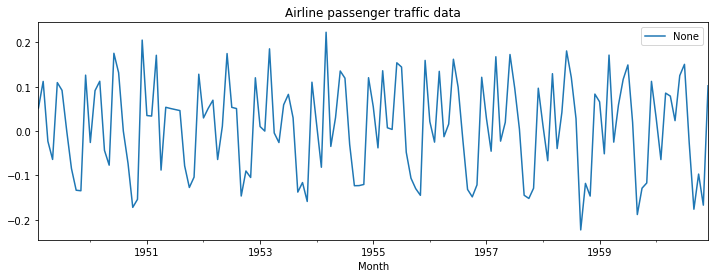

In [45]:
data_boxcox_diff = data_boxcox_diff.dropna()
data_boxcox_diff.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title("Airline passenger traffic data")
plt.show(block=False)


## ADF test

In [46]:
adf_test = adfuller(data_boxcox_diff)
adf_test
print('ADF statistic: %f' % adf_test[0])
print('Critical value @0.05: %.2f' %adf_test[4]['5%'] )
print('p-value: %f' %adf_test[1])

ADF statistic: -3.290114
Critical value @0.05: -2.88
p-value: 0.015326


## Autocorrelation function (ACF) plot

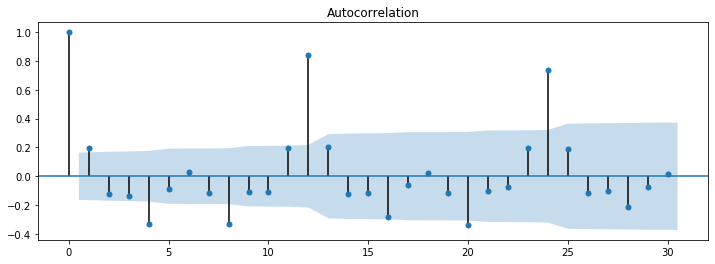

In [47]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

## Partial autocorrelation function (PACF) plot

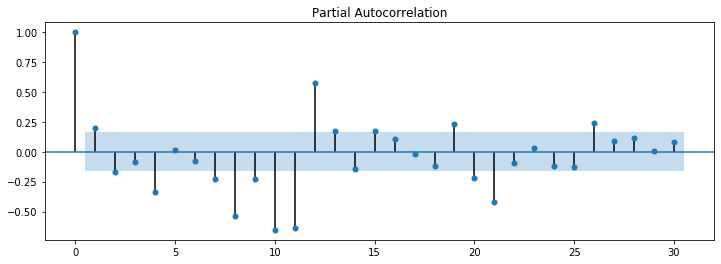

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

## Split into training and test data

In [49]:
data_boxcox_diff.index

DatetimeIndex(['1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01',
               '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01',
               '1949-10-01', '1949-11-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=143, freq=None)

In [50]:
train_len = 120
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

## Auto regression method (AR)

In [51]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order =(1, 0, 0)) # ar(1) model
model_fit = model.fit()
print(model_fit.params)

const      0.009477
ar.L1.y    0.183116
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.007886 # B0
ar.L1.y    0.155503 # B1

## Recover original series forecast

In [52]:
data_boxcox_diff.index.min(), data_boxcox_diff.index.max()

(Timestamp('1949-02-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

In [53]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Length: 143, dtype: float64

In [54]:
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max()) #predict

In [55]:
# recover step by step
y_hat_ar['ar_forecast_boxcox'] =y_hat_ar['ar_forecast_boxcox_diff'].cumsum() # undo the differencing. 
y_hat_ar['ar_forecast_boxcox'] =  y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0]) # add first term that was deleted during differencing
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox']) # reverse of log. 

# Moving Average(MA) model

In [56]:
model = ARIMA(train_data_boxcox_diff, order = (0, 0, 1)) # q =0
model_fit = model.fit()
print(model_fit.params)

const      0.009538
ma.L1.y    0.266103
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series

## Auto regressive moving average (ARMA) method

In [57]:
model= ARIMA(train_data_boxcox_diff, order = (1,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [58]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] =  model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

## Plot train, test and forecast

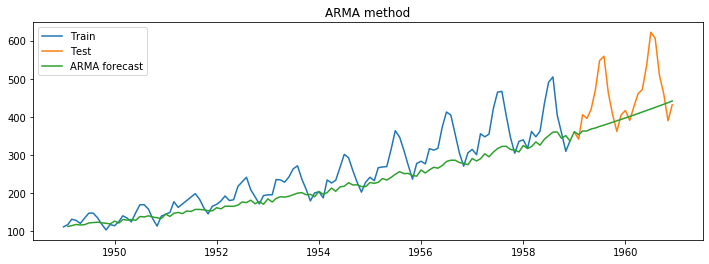

In [59]:
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_arma['arma_forecast'], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA method')
plt.show()

### Calculate RMSE and MAPE

## Auto regressive integrated moving average (ARIMA) method

In [60]:
model = ARIMA(train_data_boxcox, order = (1, 1, 1))  #use boxcox instead of data_boxcox_diff
model_fit = model.fit()
print(model_fit.params)

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [61]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arima_forecast_boxcox_diff'] =  model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arima_forecast_boxcox'] = y_hat_arma['arima_forecast_boxcox_diff'].cumsum()
y_hat_arma['arima_forecast_boxcox'] = y_hat_arma['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arima_forecast'] = np.exp(y_hat_arma['arima_forecast_boxcox'])

## Seasonal auto regressive integrated moving average(SARIMA)

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order = (1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ar.L1       0.391870
ma.L1      -0.682458
ar.S.L12   -0.040636
ma.S.L12   -0.517432
sigma2      0.001407
dtype: float64


### RECOVER ORIGINAL TIME SERIES

In [63]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# integratoin is not required
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

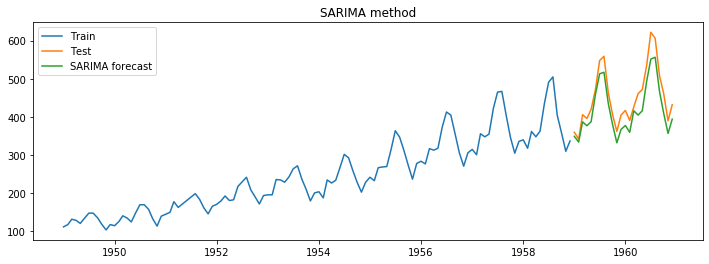

In [66]:
plt.figure(figsize=(12, 4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA method')
plt.show()

### calculate RMSE and MAPE

### Seasonal auto regressive integrated moving average with exteral variables (SARIMAX)

In [68]:
promo = pd.read_csv('promotion.csv', header=None)
promo.columns = ['Month', 'Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


In [70]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]


In [73]:
model = SARIMAX(train_data_boxcox, order =(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train)
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Event       0.034349
ar.L1       0.479264
ma.L1      -0.742286
ar.S.L12   -0.063847
ma.S.L12   -0.558147
sigma2      0.001334
dtype: float64
